# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #6
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 9th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Gibbs Sampling

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

### Part A:
Write the Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. You must justify your choice of parameters. 

**Solutions:**

Given a bivariate normal distribution with $\mu = [\mu_X, \mu_Y]$ and $\Sigma = \left[\begin{array}{cc}\sigma^2_X & \rho\sigma_X\sigma_Y\\\rho\sigma_X\sigma_Y & \sigma^2_Y\end{array}\right]$. The conditionals $p(Y | X)$ and $p(X | Y)$ are both normal with:
\begin{align}
\mathbb{E}[Y|x] &= \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), &\text{Var}[Y|x] = \sigma_Y^2(1 - \rho)\\
\mathbb{E}[X|y] &= \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), &\text{Var}[X|y] = \sigma_X^2(1 - \rho)
\end{align}

In our case, we have $\mu_X = 1, \mu_Y = 2$, $\sigma_X = \sigma_Y = 2$. Then we have $\rho = \frac{\text{Cov}[X, Y]}{\sigma_X\sigma_Y} = \frac{1.2}{4} = 0.3$.

In [13]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import uniform
from scipy.stats import gamma
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

#all the parts in the bivariate dist
sigma_x = 2
sigma_y = 2
rho = 0.3
mu_x = 1
mu_y = 2

p_x = lambda y: np.random.normal(mu_x + rho * sigma_x / sigma_y * (y - mu_y), sigma_x**2 * (1 - rho), 1)[0]
p_y = lambda x: np.random.normal(mu_y + rho * sigma_y / sigma_x * (x - mu_x), sigma_y**2 * (1 - rho), 1)[0]

def gibbs(p_x, p_y, iters, x_0, y_0, burn, thin=1):
    old_x = x_0
    old_y = y_0
    samples = [[old_x, old_y]]
    for i in range(iters):
        new_x = p_x(old_y)
        new_y = p_y(old_x)
        samples.append([new_x, new_y])
        
    return np.array(samples[int(burn * iters)::thin])

4501


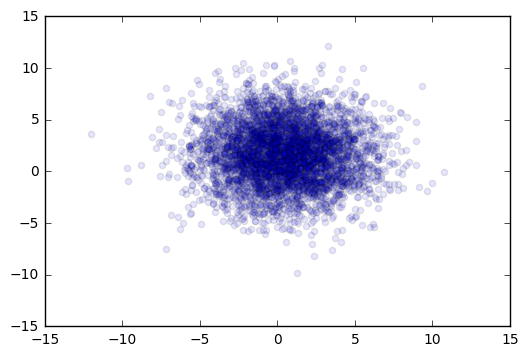

In [14]:
x_0 = 0
y_0 = 0
iters = 5000
burn = .1
samples = gibbs(p_x, p_y, iters, x_0, y_0, burn)
print len(samples)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

## Problem 2: Bayesian Inference and All That
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](lotus1.png) |  ![alt](toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](lotus2.png) |  ![alt](toysmith2.png)


In the following, we will ask you to compare these two products using the various rating statistics. Larger versions of the images are available in the data set accompanying this notebook.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

- Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

- Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

- Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
- Sample 1,000 values of $x$ from the *posterior predictive distribution*.


**Solutions:**
The Bayesian model for each product is as follows:
\begin{aligned}
p(\theta) &= \text{Dirichlet}(\theta; \alpha)\\
p(X|\theta)&= \text{Multinomial}(X; n, \theta)
\end{aligned}
where $\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]$, $\alpha = [\alpha_1, \alpha_2, \alpha_3, \alpha_4, \alpha_5]$ and $X = [X_1, X_2, X_3, X_4, X_5]$. Each $X_i$ is the number of times the product is given $i$-number of stars, each $\theta_i$ is the "likelihood" that any customer will give the product $i$-number of stars, and $\alpha_i$ is the hyperparameter controlling the "likelihood" that a larger value for $\theta_i$ is drawn.

This model models two parts:

1. The prior - here we assume that each product has a secret quality rating - this is a distribution over 1 thru 5 stars (for example, [1, 0, 0, 0, 0] might indicate that the product isn't very good). This quality rating is unknown to us. The prior represents what we believe the secret quality rating to be. So, for example, $\alpha = [1000, 1, 1, 1, 1]$ represents the (very strong) belief that this product is very poor (more specifically, when $\alpha >0$ it represents a vector of pseudo-counts, as if this these are ratings you already have prior to collecting your data).

2. The likelihood - this describes the data we actually see (i.e. the counts, how many of 5 stars and how many of 4 stars etc). Here we assume that each customer reviews the product independently and the way they do it is via the "secret quality rating" $\theta$. That is, if the secret rating of the product is $[.9, 0, 0, 0, .1]$, then there is a 90% chance that any customer will rank the product 1-star and a 10% chance that they will rank it 5 stars. Thus, each customer review is a mulinoulli or categorical trial and the total review data (the counts) can be described as a multinomial model.

Ok, so since apparently the ducks are polarizing, we'll choose the following alphas: $\alpha = [1000, 10, 10, 10, 1000]$. This is a pretty strong belief.

Then either you do some algebra or look this up. You get that the posterior is a Dirichlet, with $\alpha_{posterior} = [\alpha_1 + \text{number of 1 stars}, ..., \alpha_5 + \text{number of 5 stars}]$ and the posterior predictive is a multimoulli/categorical trial, with $\theta_i = \frac{\text{(number of i stars)} + \alpha_i}{\sum_k\text{(number of k stars)} + \alpha_k }$.

To sample from Dirichlet is easy - just go get it.

To sample from posterior predictive you can:
 
- feed the posterior samples of $\theta$ into likelihood to get new x's
- generate x's directly from the categorical class probabilities

In [23]:
alpha = [10000, 10, 10, 10, 10000]
counts_lotus = [109, 27, 10, 6, 10]
counts_toysmith = [246, 45, 29, 33, 57]

posterior_samples = np.random.dirichlet(np.array(alpha) + np.array(counts_lotus), 1000)
posterior_mean = posterior_samples.mean(axis=0)
print 'lotus posterior mean:', posterior_mean

posterior_samples = np.random.dirichlet(np.array(alpha) + np.array(counts_toysmith), 1000)
posterior_mean = posterior_samples.mean(axis=0)
print 'toysmith posterior mean:', posterior_mean

lotus posterior mean: [ 0.50085501  0.00183287  0.00099903  0.00080363  0.49550946]
toysmith posterior mean: [ 0.50119007  0.00270602  0.00189871  0.00209938  0.49210583]


In [24]:
predictive_mean = (np.array(alpha) + np.array(counts_lotus)) * 1. / (np.array(alpha) + np.array(counts_lotus)).sum()
print 'lotus posterior mean:', predictive_mean

predictive_mean = (np.array(alpha) + np.array(counts_toysmith)) * 1. / (np.array(alpha) + np.array(counts_toysmith)).sum()
print 'toysmith posterior mean:', predictive_mean

lotus posterior mean: [ 0.50064382  0.00183241  0.00099049  0.00079239  0.49574089]
toysmith posterior mean: [ 0.50127202  0.0026908   0.00190802  0.00210372  0.49202544]


### Part B: Ranking

- Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

- Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)
  
**Solutions:**

### Conclusions:

1. Note that the posterior mean is not the same as the posterior predictive mean!!! In this case they both give similar distributions. Now there is a whole school of debate about which is better (posterior or posterior predictive) for making decisions, so go read about them!

2. If you fix a distribution (either posterior or posterior predictive), you still need to decide what it means to be a better product. Should you average all the customer reviews - this is dangerous b/c then you can't tell the difference between a product with 10 5-stars and 10 1 stars vs a product with 20 3-star reviews. In this case, both products have somewhat similar distributions over stars so make a reasonable decision!